In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("hw10.ipynb")

# Homework 10: Spam/Ham Classification - Build Your Own Model
## Feature Engineering, Logistic Regression, Cross Validation
## Due Date: Thursday 11/22, 11:59 PM PST

**Collaboration Policy**

Data science is a collaborative activity. While you may talk with others about
the project, we ask that you **write your solutions individually**. If you do
discuss the assignments with others please **include their names** at the top
of your notebook.

**Collaborators**: *list collaborators here*

## This Assignment
In this homework, you will be building and improving on the concepts and functions that you implemented in homework 9 to create your own classifier to distinguish spam (junk or commercial or bulk) emails from ham (non-spam) emails. We will evaluate your work based on your model's accuracy and your written responses in this notebook.

After this assignment, you should feel comfortable with the following:

- Using `sklearn` libraries to process data and fit models
- Validating the performance of your model and minimizing overfitting
- Generating and analyzing precision-recall curves

## Warning
This is a **real world** dataset– the emails you are trying to classify are actual spam and legitimate emails. As a result, some of the spam emails may be in poor taste or be considered inappropriate. We think the benefit of working with realistic data outweighs these innapropriate emails, and wanted to give a warning at the beginning of the project so that you are made aware.

In [2]:
# Run this cell to suppress all FutureWarnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

## Score Breakdown
Question | Points
--- | ---
1 | 6
2 | 6
3 | 3
4 | 15
Total | 30

## Setup and Recap

Here we will provide a summary of the homework 9 to remind you of how we cleaned the data, explored it, and implemented methods that are going to be useful for building your own model.

In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style = "whitegrid", 
        color_codes = True,
        font_scale = 1.5)

### Loading and Cleaning Data

Remember that in email classification, our goal is to classify emails as spam or not spam (referred to as "ham") using features generated from the text in the email. 

The dataset consists of email messages and their labels (0 for ham, 1 for spam). Your labeled training dataset contains 8348 labeled examples, and the unlabeled test set contains 1000 unlabeled examples.

Run the following cell to load in the data into DataFrames.

The `train` DataFrame contains labeled data that you will use to train your model. It contains four columns:

1. `id`: An identifier for the training example
1. `subject`: The subject of the email
1. `email`: The text of the email
1. `spam`: 1 if the email is spam, 0 if the email is ham (not spam)

The `test` DataFrame contains 1000 unlabeled emails. You will predict labels for these emails and submit your predictions to the autograder for evaluation.

In [4]:
from utils import fetch_and_cache_gdrive
fetch_and_cache_gdrive('1SCASpLZFKCp2zek-toR3xeKX3DZnBSyp', 'train.csv')
fetch_and_cache_gdrive('1ZDFo9OTF96B5GP2Nzn8P8-AL7CTQXmC0', 'test.csv')

original_training_data = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

# Convert the emails to lower case as a first step to processing the text
original_training_data['email'] = original_training_data['email'].str.lower()
test['email'] = test['email'].str.lower()

original_training_data.head()

Using version already downloaded: Wed Apr 21 12:49:48 2021
MD5 hash of file: 0380c4cf72746622947b9ca5db9b8be8
Using version already downloaded: Wed Apr 21 12:49:49 2021
MD5 hash of file: a2e7abd8c7d9abf6e6fafc1d1f9ee6bf


id                                            subject  \
0   0  Subject: A&L Daily to be auctioned in bankrupt...   
1   1  Subject: Wired: "Stronger ties between ISPs an...   
2   2  Subject: It's just too small                  ...   
3   3                      Subject: liberal defnitions\n   
4   4  Subject: RE: [ILUG] Newbie seeks advice - Suse...   

                                               email  spam  
0  url: http://boingboing.net/#85534171\n date: n...     0  
1  url: http://scriptingnews.userland.com/backiss...     0  
2  <html>\n <head>\n </head>\n <body>\n <font siz...     1  
3  depends on how much over spending vs. how much...     0  
4  hehe sorry but if you hit caps lock twice the ...     0

Feel free to explore the dataset above along with any specific spam and ham emails that interest you. Keep in mind that our data may contain missing values, which are handled in the following cell.

In [5]:
# Fill any missing or NAN values
print('Before imputation:')
print(original_training_data.isnull().sum())
original_training_data = original_training_data.fillna('')
print('------------')
print('After imputation:')
print(original_training_data.isnull().sum())

Before imputation:
id         0
subject    6
email      0
spam       0
dtype: int64
------------
After imputation:
id         0
subject    0
email      0
spam       0
dtype: int64


### Training/Validation Split

Recall that the training data we downloaded is all the data we have available for both training models and **validating** the models that we train. We therefore split the training data into separate training and validation datsets. You will need this **validation data** to assess the performance of your classifier once you are finished training. 

As in homework 9, we set the seed (random_state) to 42. **Do not modify this in the following questions, as our tests depend on this random seed.**

In [6]:
# This creates a 90/10 train-validation split on our labeled data
from sklearn.model_selection import train_test_split
train, val = train_test_split(original_training_data, test_size=0.1, random_state=42)

# We must do this in order to preserve the ordering of emails to labels for words_in_texts
train = train.reset_index(drop=True)

### Feature Engineering

In order to train a logistic regression model, we need a numeric feature matrix $X$ and a vector of corresponding binary labels $y$. To address this, in homework 9, we implemented the function `words_in_texts`, which creates numeric features derived from the email text and uses those features for logistic regression. 

For this homework, we have provided you with an implemented version of `words_in_texts`. Remember that the function outputs a 2-dimensional NumPy array containing one row for each email text. The row should contain either a 0 or a 1 for each word in the list: 0 if the word doesn't appear in the text and 1 if the word does. 

In [7]:
def words_in_texts(words, texts):
    '''
    Args:
        words (list): words to find
        texts (Series): strings to search in
    
    Returns:
        NumPy array of 0s and 1s with shape (n, p) where n is the
        number of texts and p is the number of words.
    '''
    import numpy as np
    indicator_array = 1 * np.array([texts.str.contains(word) for word in words]).T
    return indicator_array

Run the following cell to see how the function works on some dummy text.

In [8]:
words_in_texts(['hello', 'bye', 'world'], pd.Series(['hello', 'hello worldhello']))

array([[1, 0, 0],
       [1, 0, 1]])

### EDA and Basic Classification

In homework 9, we proceeded to visualize the frequency of different words for both spam and ham emails, and used `words_in_texts(words, train['email'])` to directly to train a classifier. We also provided a simple set of 5 words that might be useful as features to distinguish spam/ham emails. 

We then built a model using the using the [`LogisticRegression`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) classifier from `scikit-learn`.

Run the following cell to see the performance of a simple model using these words and the `train` dataframe.

In [9]:
some_words = ['drug', 'bank', 'prescription', 'memo', 'private']

X_train = words_in_texts(some_words, train['email'])
Y_train = train['spam']

X_train[:5], Y_train[:5]

(array([[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0]]),
 0    0
 1    0
 2    0
 3    0
 4    0
 Name: spam, dtype: int64)

In [10]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train, Y_train)


training_accuracy = model.score(X_train, Y_train)
print("Training Accuracy: ", training_accuracy)

Training Accuracy:  0.7576201251164648


### Evaluating Classifiers

In our models, we are evaluating accuracy on the training set, which may provide a misleading accuracy measure. In homework 9, we calculated various metrics to lead us to consider more ways of evaluating a classifier, in addition to overall accuracy. Below is a reference to those concepts.

Presumably, our classifier will be used for **filtering**, i.e. preventing messages labeled `spam` from reaching someone's inbox. There are two kinds of errors we can make:
- False positive (FP): a ham email gets flagged as spam and filtered out of the inbox.
- False negative (FN): a spam email gets mislabeled as ham and ends up in the inbox.

To be clear, we label spam emails as 1 and ham emails as 0. These definitions depend both on the true labels and the predicted labels. False positives and false negatives may be of differing importance, leading us to consider more ways of evaluating a classifier, in addition to overall accuracy:

**Precision** measures the proportion $\frac{\text{TP}}{\text{TP} + \text{FP}}$ of emails flagged as spam that are actually spam.

**Recall** measures the proportion $\frac{\text{TP}}{\text{TP} + \text{FN}}$ of spam emails that were correctly flagged as spam. 

**False-alarm rate** measures the proportion $\frac{\text{FP}}{\text{FP} + \text{TN}}$ of ham emails that were incorrectly flagged as spam. 

The two graphics below may help you understand precision and recall visually:

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/2/26/Precisionrecall.svg/700px-Precisionrecall.svg.png" width="500px">

Note that a true positive (TP) is a spam email that is classified as spam, and a true negative (TN) is a ham email that is classified as ham.

# Moving Forward - Building Your Own Model

With this in mind, it is now your task to make the spam filter more accurate. In order to get full credit on the accuracy part of this assignment, you must get at least **88%** accuracy on the test set. To see your accuracy on the test set, you will use your classifier to predict every email in the `test` DataFrame and upload your predictions to Gradescope.

**Gradescope limits you to four submissions per day**. This means you should start early so you have time if needed to refine your model. You will be able to see your accuracy on 70% of the test set when submitting to Gradescope, but we will be evaluating your model on the entire test set so try to score slightly above 88% on gradescope if you can.

Here are some ideas for improving your model:

1. Finding better features based on the email text. Some example features are:
    1. Number of characters in the subject / body
    1. Number of words in the subject / body
    1. Use of punctuation (e.g., how many '!'s were there?)
    1. Number / percentage of capital letters 
    1. Whether the email is a reply to an earlier email or a forwarded email
1. Finding better (and/or more) words to use as features. Which words are the best at distinguishing emails? This requires digging into the email text itself. 
1. Better data processing. For example, many emails contain HTML as well as text. You can consider extracting out the text from the HTML to help you find better words. Or, you can match HTML tags themselves, or even some combination of the two.
1. Model selection. You can adjust parameters of your model (e.g. the regularization parameter) to achieve higher accuracy. Recall that you should use cross-validation to do feature and model selection properly! Otherwise, you will likely overfit to your training data.

You may use whatever method you prefer in order to create features, but **you are not allowed to import any external feature extraction libraries**. In addition, **you are only allowed to train logistic regression models**. No random forests, k-nearest-neighbors, neural nets, etc.

We have not provided any code to do this, so feel free to create as many cells as you need in order to tackle this task. However, answering questions 7, 8, and 9 should help guide you.

---

**Note:** *You may want to use your **validation data** to evaluate your model and get a better sense of how it will perform on the test set.* Note, however, that you may overfit to your validation set if you try to optimize your validation accuracy too much.

---

<!-- BEGIN QUESTION -->

### Question 1: Feature/Model Selection Process

In this following cell, describe the process of improving your model. You should use at least 2-3 sentences each to address the follow questions:

1. How did you find better features for your model?
2. What did you try that worked or didn't work?
3. What was surprising in your search for good features?

<!--
BEGIN QUESTION
name: q1
manual: True
points: 6
-->

In [11]:
pd.set_option('display.max_rows', None)

#### Useful Functions

In [12]:
def find_the_count_in_email(df, pattern):
    word_count_list = []
    
    for line in df['email']:
        l = re.findall(pattern, line)
        word_count = len(l)
        word_count_list.append(word_count)
    return pd.Series(word_count_list)

In [13]:
def find_the_count_in_subject(df, pattern):
    word_count_list = []
    
    for line in df['subject']:
        l = re.findall(pattern, line)
        word_count = len(l)
        word_count_list.append(word_count)
    return pd.Series(word_count_list)

#### Number of characters in the subject / body

In [14]:
train

id                                            subject  \
0     7657             Subject: Patch to enable/disable log\n   
1     6911        Subject: When an engineer flaps his wings\n   
2     6074  Subject: Re: [Razor-users] razor plugins for m...   
3     4376  Subject: NYTimes.com Article: Stop Those Press...   
4     5766  Subject: What's facing FBI's new CIO? (Tech Up...   
5     5247                                    Subject: asap\n   
6     7410     Subject: [use Perl] Headlines for 2002-09-18\n   
7      576  Subject: Cost price Guinness, Budweiser and se...   
8     4398  Subject: Play by Play: Effective Memory Manage...   
9     3989  Subject: Sheila Lennon was interviewed for the...   
10    3686        Subject: Re: Slaughter in the Name of God\n   
11    4509     Subject: Re: RedHat 8.0 and his own freetype\n   
12    4176  Subject: PKI smartcard/CA/profile/email/softwa...   
13     354                       Subject: Re: Your VIP Pass\n   
14     415               Subject: Re: Forged whitelist spam\n   
15    6449  Subject: wives and girlfriends cheating and wh...   
16    7534          Subject: Lander risks missing Mars trip\n   
17    7230   Subject: Blair attacks new culture of cynicism\n   
18    5338  Subject: Fw: Offring Membership To 16 Sites Fo...   
19    5366      Subject: The Government grants you $25,000!\n   
20    2692      Subject: I saw your email 7272Gtnz8-338r-13\n   
21     177               Subject: Re: traceback in new exmh\n   
22    7713       Subject: Re: [ILUG] How to copy some files\n   
23    1323      Subject: Re: [ILUG] [OT] GPL & PHP Question\n   
24    8316            Subject: Say "Goodbye" to the 9-5 yhe\n   
25    2372  Subject: New Gunner Gilberto is quick to earn ...   
26    6207  Subject: Re: [SAtalk] How'd this one slip thro...   
27    7851  Subject: [ILUG] $4,000/Month with your PC ! NO...   
28    7054  Subject: =?big5?Q?=A7K=B6O=B5L=AD=AD=A6=B8=A5=...   
29    4017   Subject: [SAtalk] [OT] SpamAssassin figures...\n   
30    4464  Subject: [SAtalk] moving SPAM: results to bott...   
31    3131  Subject: NY Times: "Google's automated editors...   
32    5948            Subject: HGH Myth --- Learn the Truth\n   
33     328  Subject: Re: [SAtalk] checking out Razor2 (and...   
34    4557  Subject: Re: [SAtalk] Re: patent on TMDA-like ...   
35    4184    Subject: Synthetic vitamin boosts bone growth\n   
36    3826             Subject: Movies to Watch on Lifetime\n   
37    2405       Subject: [use Perl] Stories for 2002-09-11\n   
38    5419  Subject: Iowa: "There was frost outside this m...   
39    4953                       Subject: [ILUG] ASSISTANCE\n   
40    5960                Subject: [ILUG] assistance needed\n   
41    2208                              Subject: Re: remove\n   
42    5608     Subject: [use Perl] Headlines for 2002-09-26\n   
43    1426                    Subject: Vary your interests!\n   
44    2031  Subject: Re: [VoID] a new low on the personals...   
45    1261             Subject: Re: [ILUG] Backup solutions\n   
46    2874                 Subject: [ILUG] Dialup on debian\n   
47    1322  Subject: Do you have a handlebar moustache? Th...   
48    2992      Subject: Re: [ILUG] adsl router modem combo\n   
49    2112  Subject: Comrade Communism (was Re: Crony Capi...   
50    8239  Subject: Telecom Consolidation Begins to Accel...   
51    6066  Subject: [SAtalk] Terry Ryan/Chesco is out of ...   
52    2310                     Subject: Re: Apt 0.3 and 0.5\n   
53    5925  Subject: Introducing HGH: The Most Powerful An...   
54    7663  Subject: Re: [SAtalk] German spam corpus / for...   
55    4301   Subject: Gearheads and bunnyhuggers in the OED\n   
56    7568  Subject: SoE at UCSC looking for an experience...   
57    3739  Subject: Online Credit Repair,Approved by Bure...   
58     181                                  Subject: Doom 3\n   
59    4564                  Subject: Head & Rotor VE  07/26\n   
60    3309  Subject: [SACVS] CVS: spamassas

In [15]:
ham = train[train['spam'] == 0]

In [16]:
spam = train[train['spam'] == 1]

In [17]:
#number of characteds in subject
def num_char_in_df(df, col):
    char_num_list = []
    #col = str(col)
    char = df[col].str.findall('\w')
    for entry in char:
        char_num_list.append(len(entry))
        #print(len(entry))
    return char_num_list 

In [18]:
train_subject_char_h = num_char_in_df(ham, 'subject')
train_body_char_h = num_char_in_df(ham, 'email')

In [19]:
train_subject_char_s = num_char_in_df(spam, 'subject')
train_body_char_s = num_char_in_df(spam, 'email')

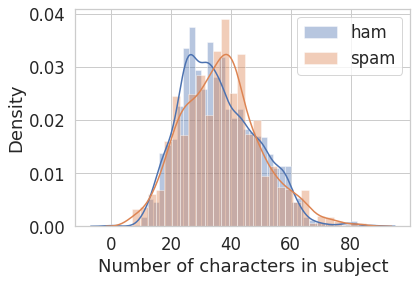

In [20]:
sns.distplot(train_subject_char_h, label = 'ham')
sns.distplot(train_subject_char_s, label = 'spam')
plt.xlabel('Number of characters in subject')
plt.legend()

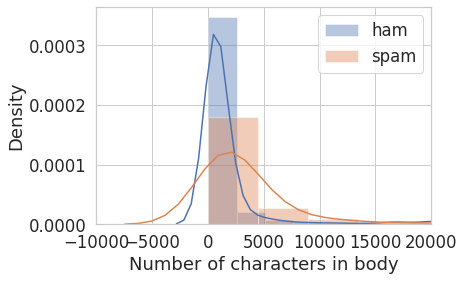

In [21]:
sns.distplot(train_body_char_h, label = 'ham')
sns.distplot(train_body_char_s, label = 'spam')
plt.xlabel('Number of characters in body')
plt.xlim(-10000, 20000)
plt.legend()

- similar distribution in the 'number of characters in the subject'; however, body seems to contain less characters in the spam comparing to ham.
* can be used as useful feature

In [22]:
pattern_ch = r"\w"

#### Number of words in the subject / body

In [23]:
import re

In [24]:
pattern_w = r'\w+'

In [25]:
ham_word_count_list = find_the_count_in_email(ham, pattern_w)
spam_word_count_list = find_the_count_in_email(spam, pattern_w)

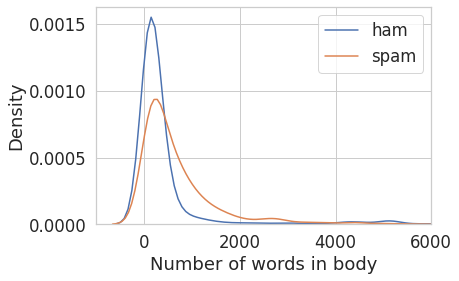

In [26]:
sns.distplot(ham_word_count_list, label = 'ham', hist=False)
sns.distplot(spam_word_count_list, label = 'spam', hist=False)
plt.xlim(-1000, 6000)
plt.xlabel('Number of words in body')
plt.legend()

- the number of words in ham email body is more than in spam email body, but this feature is similar to finding the number of characters in body, which didn't really add much addition information to the prediction model. 

#### Use of html tag

In [27]:
pattern_html = r"<html>"

In [28]:
ham_html_count_list = find_the_count_in_email(ham, pattern_html)
spam_html_count_list = find_the_count_in_email(spam, pattern_html)

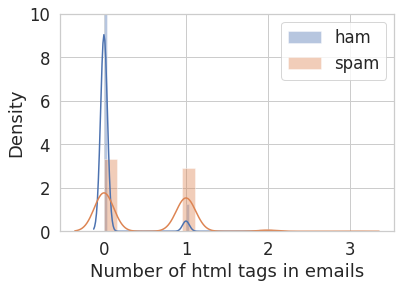

In [29]:
sns.distplot(ham_html_count_list, label = 'ham')
sns.distplot(spam_html_count_list, label = 'spam')
plt.xlabel('Number of html tags in emails')
plt.ylim(0, 10)
plt.legend()

- the use of html tags is significantly less in ham than in spam! Which could be used in the feature selection. 

#### Use of punctuation 

In [30]:
# Use of punctuation in email ('!' )
pattern_punc = r'!'
ham_punc_count_list = find_the_count_in_email(ham, pattern_punc)
spam_punc_count_list = find_the_count_in_email(spam, pattern_punc)

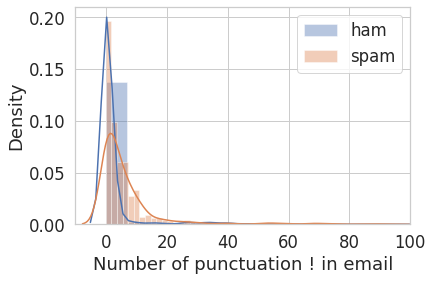

In [31]:
sns.distplot(ham_punc_count_list, label = 'ham')
sns.distplot(spam_punc_count_list, label = 'spam')
plt.xlabel('Number of punctuation ! in email')
plt.xlim(-10, 100)
plt.legend()

In [32]:
sum(spam_punc_count_list) / len(spam['email'])

6.470281543274244

In [33]:
sum(ham_punc_count_list) / len(ham['email'])

2.0875781948168006

- More(almost 3 folds) ! is used in spam than ham! Which could be used in the final model. 

#### Non character use in subject

In [34]:
non_char_pattern = r'[^A-Za-z0-9]'
ham_non_char_count_list = find_the_count_in_subject(ham, non_char_pattern)
spam_non_char_count_list = find_the_count_in_subject(spam, non_char_pattern)

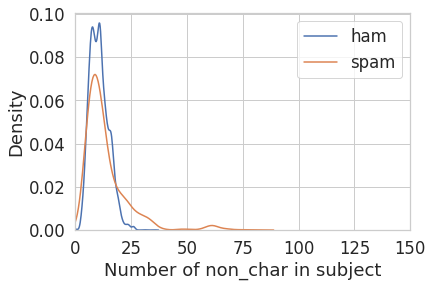

In [35]:
sns.distplot(ham_non_char_count_list, label = 'ham', hist=False)
sns.distplot(spam_non_char_count_list, label = 'spam', hist=False)
plt.xlabel('Number of non_char in subject')
plt.xlim(0, 150)
plt.legend()

- noticable difference in spam and ham in using non-characters in subject line, could be useful feature

#### Number / percentage of capital letters

In [36]:
pattern_cap = r'[A-Z]'

In [37]:
ham_cap_in_subject_count_list = find_the_count_in_subject(ham, pattern_cap)
spam_cap_in_subject_count_list = find_the_count_in_subject(spam, pattern_cap)

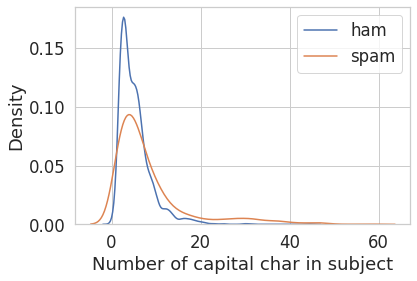

In [38]:
sns.distplot(ham_cap_in_subject_count_list, label = 'ham', hist=False)
sns.distplot(spam_cap_in_subject_count_list, label = 'spam', hist=False)
plt.xlabel('Number of capital char in subject')
#plt.xlim(0, 200)
plt.legend()

In [68]:
ham_cap_in_body_count_list = find_the_count_in_email(ham, pattern_cap)
spam_cap_in_body_count_list = find_the_count_in_email(spam, pattern_cap)

No handles with labels found to put in legend.


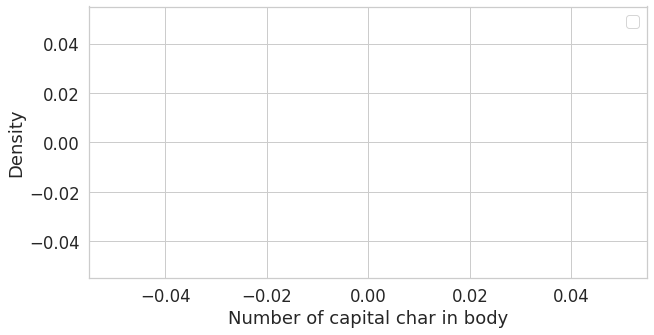

In [69]:
sns.distplot(ham_cap_in_body_count_list, label = 'ham', hist=False)
sns.distplot(spam_cap_in_body_count_list, label = 'spam', hist=False)
plt.xlabel('Number of capital char in body')
#plt.xlim(0, 200)
plt.legend()

- no capital letter find because we used .lower in the preprocessing 

In [41]:
#non-cap words
pattern_non_cap = r'[a-z]'
ham_no_cap_in_body_count_list = find_the_count_in_email(ham, pattern_non_cap)
spam_no_cap_in_body_count_list = find_the_count_in_email(spam, pattern_non_cap)

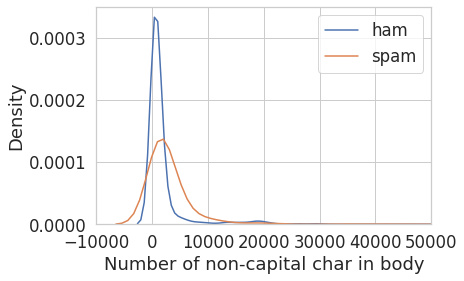

In [42]:
sns.distplot(ham_no_cap_in_body_count_list, label = 'ham', hist=False)
sns.distplot(spam_no_cap_in_body_count_list, label = 'spam', hist=False)
plt.xlabel('Number of non-capital char in body')
plt.xlim(-10000, 50000)
plt.legend()

- the use of capital letters in subject line has a bigger difference in distibution between ham and spam, could be a useful feature

#### Whether the email is a reply to an earlier email or a forwarded email

In [43]:
pattern_re = r"Re:"
pattern_forward = r"Fw:"

In [44]:
ham_re_count_list = find_the_count_in_subject(ham, pattern_re)
spam_re_count_list = find_the_count_in_subject(spam, pattern_re)
ham_fw_count_list = find_the_count_in_subject(ham, pattern_forward)
spam_fw_count_list = find_the_count_in_subject(spam, pattern_forward)

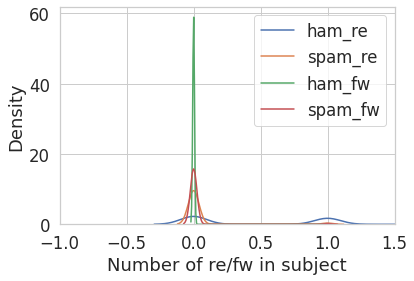

In [45]:
sns.distplot(ham_re_count_list, label = 'ham_re', hist=False)
sns.distplot(spam_re_count_list, label = 'spam_re', hist=False)
sns.distplot(ham_fw_count_list, label = 'ham_fw', hist=False)
sns.distplot(spam_fw_count_list, label = 'spam_fw', hist=False)
plt.xlabel('Number of re/fw in subject')
plt.xlim(-1, 1.5)
plt.legend()

In [46]:
#proportions in ham emails
print('#ham forward: ', sum(ham_fw_count_list))
print('prop ham forward: ', sum(ham_fw_count_list) / len(ham['subject']))
print('---')
print('#ham reply: ', sum(ham_re_count_list))
print('prop ham reply: ', sum(ham_re_count_list) / len(ham['subject']))

#ham forward:  8
prop ham forward:  0.0014298480786416443
---
#ham reply:  2663
prop ham reply:  0.47596067917783735


In [47]:
#proportions in spam emails
print('#spam forward: ',sum(spam_fw_count_list))
print('prop spam forward: ', sum(spam_fw_count_list) / len(spam['subject']))
print('---')

print('#spam reply: ',sum(spam_re_count_list))
print('prop spam reply: ', sum(spam_re_count_list) / len(spam['subject']))

#spam forward:  25
prop spam forward:  0.013034410844629822
---
#spam reply:  66
prop spam reply:  0.03441084462982273


- a noticeable difference between spam and ham eamils, lots of reply in ham, which could be a useful feature in the model. 

#### Dig into the Email words

In [72]:
def word_bags(df):
    word_count_list = {}
    
    for email in df['email']:
        word_list = re.findall('\w+', email)
        
        for word in word_list:
            if word in word_count_list:
                word_count_list[word] = (word_count_list[word] + 1)  
            else:
                word_count_list[word] =1
    return word_count_list

In [73]:
spam_word = word_bags(spam)

In [75]:
#top spammy words
pd.Series(spam_word).sort_values(ascending=False)[:20]

3d       45399
font     43157
td       22111
the      21199
a        20207
to       19974
br       18142
size     15962
b        14821
and      14687
you      13982
tr       13134
of       12801
width    11812
face     11609
p        11580
color    11438
http     11145
nbsp     10610
com       8585
dtype: int64

In [76]:
# top training words
train_word_bag = (pd.Series(word_bags(train)) / train.shape[0]).sort_values(ascending=False)[:200]
training_words = train_word_bag.index.tolist()

#### Final Model Feature Selection

In [77]:
#Final regression model with cv 
from sklearn.linear_model import LogisticRegressionCV

def process_data_set(df):
    #get the bag of words
    some_words = ['drug', 'bank', '$', 'free', 'money', '!',
                  'offer', 'business', 'body', 'html', 'please', 
                  'account', 'buy', 'gift','good'] + training_words
    
    #matrix
    X_train = np.array(words_in_texts(some_words, df['email'])).astype(int)

    #feature selections based on the EDA
    feature = pd.concat([

        
        #count of characters in email
        find_the_count_in_email(df, pattern_ch),
        
        #count the html tag using 
        find_the_count_in_email(df, pattern_html),
        
        #count of forward and reply in subject 
        find_the_count_in_subject(df, pattern_forward),
        find_the_count_in_subject(df, pattern_re),
        
        #count of capital letters in subject and body
        find_the_count_in_subject(df, pattern_cap),
        find_the_count_in_email(df, pattern_cap),
        
        #count of non capital letters in body
        #find_the_count_in_email(df, pattern_non_cap), 
        
        #count the ! usage
        find_the_count_in_email(df, pattern_punc),
        
        #cound of non characters in subject 
        find_the_count_in_subject(df, non_char_pattern)], axis=1).values
        
        
    #added features
    X_train = np.concatenate((X_train, feature), axis=1)
    return X_train

In [78]:
import warnings
warnings.filterwarnings('ignore')

#generating X/Y train 
X_train = process_data_set(train)
Y_train = train['spam']

#create final logistic regress model with cross validation 
model_final = LogisticRegressionCV(Cs=4, fit_intercept=True, verbose =1, cv=10,random_state=42)
model_final.fit(X_train, Y_train)

#training accuracy 
training_accuracy = model_final.score(X_train, Y_train)
print("Training Accuracy: ", training_accuracy)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   27.4s finished


Training Accuracy:  0.9629974710501797


1. How did you find better features for your model?
    - Visulization, compare the changes in distribution base on features in hams and spam emails. 
    - And then within the ones that are visually different, I tested it in the final model, compare the training accuracy adding and removing them. 
2. What did you try that worked or didn't work?
    - The capital characters in emails doesn't work because the .lower() at beginning.
    - The non_cap characters count doesn't improve model prediction power, so I didn't include it in the final model 
    - Most of my intuition about spam emails worked well, for example, the ! mark, the capital letters in subject line, the amount of words in subject line, the non_character in subject and body. 
3. What was surprising in your search for good features?
    - looking at the bad of words, some of the top words doesn't appear to be spammy, like the numbers: 3rd, 45399 and such, might be some identification or zip code? 
 

<!-- END QUESTION -->



### Question 2: EDA

In the cell below, show a visualization that you used to select features for your model. 

Include:

1. A plot showing something meaningful about the data that helped you during feature selection, model selection, or both.
2. Two or three sentences describing what you plotted and its implications with respect to your features.

Feel free to create as many plots as you want in your process of feature selection, but select only one for the response cell below.

**You should not just produce an identical visualization to question 3.** Specifically, don't show us a bar chart of proportions, or a one-dimensional class-conditional density plot. Any other plot is acceptable, **as long as it comes with thoughtful commentary.** Here are some ideas:

1. Consider the correlation between multiple features (look up correlation plots and `sns.heatmap`). 
1. Try to show redundancy in a group of features (e.g. `body` and `html` might co-occur relatively frequently, or you might be able to design a feature that captures all html tags and compare it to these). 
1. Visualize which words have high or low values for some useful statistic.
1. Visually depict whether spam emails tend to be wordier (in some sense) than ham emails.

<!-- BEGIN QUESTION -->

Generate your visualization in the cell below and provide your description in a comment.

<!--
BEGIN QUESTION
name: q2
manual: True
format: image
points: 6
-->

In [79]:
# Write your description (2-3 sentences) as a comment here:
# body and html might co-occur relatively frequently
#bigger variance in for tag html, spams have more '<body>', which might indicates spam emails tend to be wordier than ham. 
# overall ham has smaller distribution in both of these words, or tags comparing to spam

# Write the code to generate your visualization here:

#spam distribution
x_spam = find_the_count_in_email(spam, r'html')
y_spam = find_the_count_in_email(spam, r'body')

#ham distribution
x_ham = find_the_count_in_email(ham, r'html')
y_ham = find_the_count_in_email(ham, r'body')


In [80]:
plt.rcParams["figure.figsize"] = [10, 5]

Text(0, 0.5, 'body')

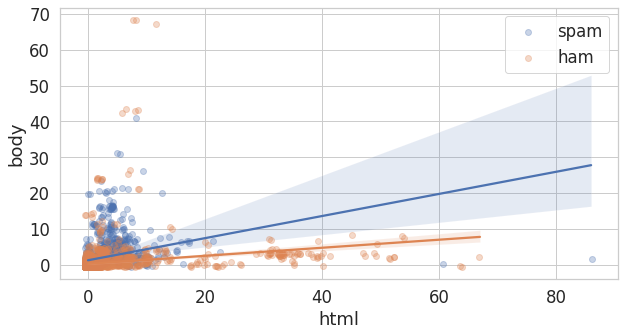

In [81]:
sns.regplot(x = x_spam, 
                 y= y_spam,
                 x_jitter=0.5, y_jitter=0.6, label = "spam", scatter_kws = {"alpha":0.3})

sns.regplot(x = x_ham, 
                 y= y_ham,
                 x_jitter=0.5, y_jitter=0.6, label = "ham", scatter_kws = {"alpha":0.3})


plt.legend()
plt.xlabel('html')
plt.ylabel('body')

Text(0, 0.5, 'body')

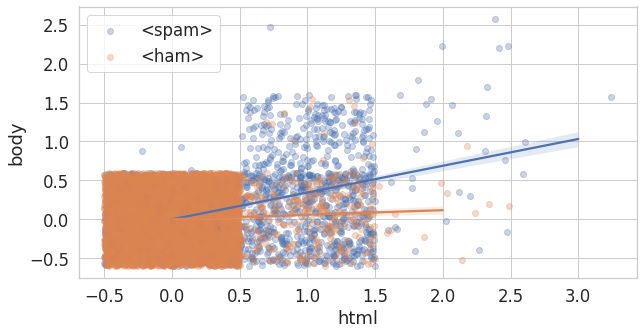

In [82]:
sns.regplot(x = find_the_count_in_email(spam, r'<html>'), 
                 y= find_the_count_in_email(spam, r'<body>'),
                 x_jitter=0.5, y_jitter=0.6, label = "<spam>", scatter_kws = {"alpha":0.3})

sns.regplot(x = find_the_count_in_email(ham, r'<html>'), 
                 y= find_the_count_in_email(ham, r'<body>'),
                 x_jitter=0.5, y_jitter=0.6, label = "<ham>", scatter_kws = {"alpha":0.3})
plt.legend()
plt.xlabel('html')
plt.ylabel('body')

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 3: ROC Curve

In most cases we won't be able to get 0 false positives and 0 false negatives, so we have to compromise. For example, in the case of cancer screenings, false negatives are comparatively worse than false positives — a false negative means that a patient might not discover that they have cancer until it's too late, whereas a patient can just receive another screening for a false positive.

Recall that logistic regression calculates the probability that an example belongs to a certain class. Then, to classify an example we say that an email is spam if our classifier gives it $\ge 0.5$ probability of being spam. However, *we can adjust that cutoff*: we can say that an email is spam only if our classifier gives it $\ge 0.7$ probability of being spam, for example. This is how we can trade off false positives and false negatives.

The ROC curve shows this trade off for each possible cutoff probability. In the cell below, plot a ROC curve for your final classifier (the one you use to make predictions for Gradescope) on the training data. Refer to Lecture 20 or [Section 23.7](http://www.textbook.ds100.org/ch/23/classification_sensitivity_specificity.html?highlight=roc#roc-curves) of the course text to see how to plot an ROC curve.

<!--
BEGIN QUESTION
name: q3
manual: True
points: 3
-->

In [83]:
from sklearn.metrics import roc_curve


# Note that you'll want to use the .predict_proba(...) method for your classifier
# instead of .predict(...) so you get probabilities, not classes

scores = []

for i in model_final.predict_proba(X_train):
    scores.append(i[1])
    
    
fpr, tpr, thresholds = roc_curve(Y_train, scores, pos_label=1)

Text(0.5, 1.0, 'ROC Curve')

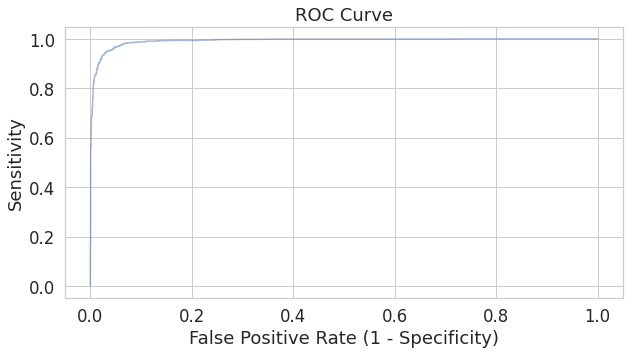

In [84]:
plt.step(fpr, tpr, color='b', alpha=0.5,
         where='post')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('Sensitivity')
plt.title('ROC Curve')

<!-- END QUESTION -->

# Question 4: Test Predictions

The following code will write your predictions on the test dataset to a CSV file. **You will need to submit this file to the "Homework 10 Test Predictions" assignment on Gradescope to get credit for this question.**

Save your predictions in a 1-dimensional array called `test_predictions`. **Please make sure you've saved your predictions to `test_predictions` as this is how part of your score for this question will be determined.**

Remember that if you've performed transformations or featurization on the training data, you must also perform the same transformations on the test data in order to make predictions. For example, if you've created features for the words "drug" and "money" on the training data, you must also extract the same features in order to use scikit-learn's `.predict(...)` method.

**Note: You may submit up to 4 times a day. If you have submitted 4 times on a day, you will need to wait until the next day for more submissions.**

Note that this question is graded on an absolute scale based on the accuracy your model achieves on the overall test set, and as such, your score does not depend on your ranking on Gradescope. Your public Gradescope results are based off of your classifier's accuracy on 70% of the test dataset and your score for this question will be based off of your classifier's accuracy on 100% of the test set.

*The provided tests check that your predictions are in the correct format, but you must additionally submit to Gradescope to evaluate your classifier accuracy.*

<!--
BEGIN QUESTION
name: q4
points: 3
-->

In [85]:
# Fill any missing or NAN values
print('Before imputation:')
print(test.isnull().sum())
original_training_data = test.fillna('', inplace=True)
print('------------')
print('After imputation:')
print(test.isnull().sum())

Before imputation:
id         0
subject    0
email      0
dtype: int64
------------
After imputation:
id         0
subject    0
email      0
dtype: int64


In [86]:
X_test = process_data_set(test)
test_predictions = model_final.predict(X_test)
test_predictions


array([0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1,

In [87]:
grader.check("q4")

q4 passed!

The following cell generates a CSV file with your predictions. **You must submit this CSV file to the "Homework 10 Test Predictions" assignment on Gradescope to get credit for this question.**

In [88]:
from datetime import datetime

# Assuming that your predictions on the test set are stored in a 1-dimensional array called
# test_predictions. Feel free to modify this cell as long you create a CSV in the right format.

# Construct and save the submission:
submission_df = pd.DataFrame({
    "Id": test['id'], 
    "Class": test_predictions,
}, columns=['Id', 'Class'])
timestamp = datetime.isoformat(datetime.now()).split(".")[0]
submission_df.to_csv("submission_{}.csv".format(timestamp), index=False)

print('Created a CSV file: {}.'.format("submission_{}.csv".format(timestamp)))
print('You may now upload this CSV file to Gradescope for scoring.')

Created a CSV file: submission_2021-04-22T22:52:41.csv.
You may now upload this CSV file to Gradescope for scoring.


## Congratulations! You have completed homework 10!

---

To double-check your work, the cell below will rerun all of the autograder tests.

In [89]:
grader.check_all()

q4 passed!

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [ ]:
# Save your notebook first, then run this cell to export your submission.
grader.export()